In [ ]:
!pip install pennylane pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 97.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.4/130.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.9/242.9 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 110.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 141.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pennylane as qml
# Just like standard NumPy, but with the added benefit of automatic differentiation
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive

drive.mount('/content/drive/', force_remount=True)
%cd '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive/
/content/drive/My Drive/Colab Notebooks


In [ ]:
n_epochs = 60
n_layers = 1
n_train = 1000
n_test = 400

SAVE_PATH = "quanvolution/"
PREPROCESS = True           # False --> skip quantum processing and load data from SAVE_PATH
np.random.seed(0)
tf.random.set_seed(0)

NameError: name 'np' is not defined

In [ ]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension (for convolution channels)
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [ ]:
#dev = qml.device("default.qubit", wires=4)
dev = qml.device('qiskit.aer', wires=4, backend='statevector_simulator')

# Random circuit parameters
rand_params = np.random.uniform(high=2*np.pi, size=(n_layers, 4))

# To convert the function into a QNode running on dev, we apply the qnode() decorator
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi*phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement (expect. val.) producing 4 classical outputs
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit"""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a 2x2 region with the quantum circuit
            q_results = circuit(
                [image[j, k, 0], image[j, k + 1, 0],
                 image[j + 1, k, 0], image[j + 1, k + 1, 0]]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [ ]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print(f"{idx + 1}/{n_train}        ", end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print(f"{idx + 1}/{n_test}        ", end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


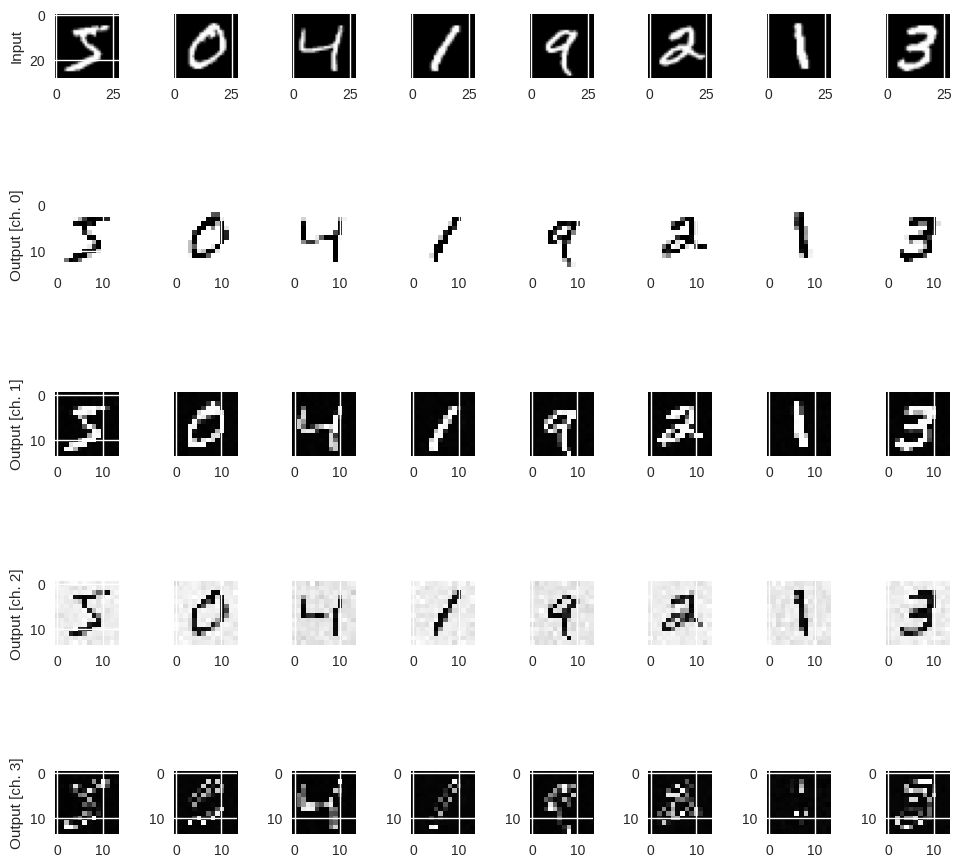

In [ ]:
n_samples = 8
n_channels = 4

fig, axes = plt.subplots(1+n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel(f"Output [ch. {c}]")
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.savefig(f'out_q_layer_{n_samples}_samples.png', dpi=300, facecolor='w')
plt.show()

In [ ]:
def model():
    """Initializes and returns a Keras model to be trained"""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [ ]:
q_model = model()

q_history = q_model.fit(q_train_images, train_labels,
                        validation_data=(q_test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

Epoch 1/60
250/250 - 1s - loss: 1.3977 - accuracy: 0.5610 - val_loss: 0.9729 - val_accuracy: 0.7175 - 754ms/epoch - 3ms/step
Epoch 2/60
250/250 - 0s - loss: 0.6571 - accuracy: 0.8100 - val_loss: 0.7339 - val_accuracy: 0.7900 - 400ms/epoch - 2ms/step
Epoch 3/60
250/250 - 0s - loss: 0.4985 - accuracy: 0.8680 - val_loss: 0.6093 - val_accuracy: 0.8275 - 316ms/epoch - 1ms/step
Epoch 4/60
250/250 - 0s - loss: 0.4005 - accuracy: 0.8990 - val_loss: 0.5795 - val_accuracy: 0.8200 - 369ms/epoch - 1ms/step
Epoch 5/60
250/250 - 0s - loss: 0.3633 - accuracy: 0.9020 - val_loss: 0.6652 - val_accuracy: 0.7625 - 490ms/epoch - 2ms/step
Epoch 6/60
250/250 - 0s - loss: 0.3090 - accuracy: 0.9180 - val_loss: 0.4783 - val_accuracy: 0.8425 - 419ms/epoch - 2ms/step
Epoch 7/60
250/250 - 0s - loss: 0.2574 - accuracy: 0.9400 - val_loss: 0.4598 - val_accuracy: 0.8525 - 405ms/epoch - 2ms/step
Epoch 8/60
250/250 - 0s - loss: 0.2325 - accuracy: 0.9390 - val_loss: 0.4790 - val_accuracy: 0.8325 - 425ms/epoch - 2ms/step


In [ ]:
c_model = model()

c_history = c_model.fit(train_images, train_labels,
                        validation_data=(test_images, test_labels),
                        batch_size=4, epochs=n_epochs, verbose=2)

Epoch 1/60
250/250 - 1s - loss: 1.3661 - accuracy: 0.6430 - val_loss: 0.9856 - val_accuracy: 0.7625 - 714ms/epoch - 3ms/step
Epoch 2/60
250/250 - 0s - loss: 0.6429 - accuracy: 0.8590 - val_loss: 0.7236 - val_accuracy: 0.8075 - 390ms/epoch - 2ms/step
Epoch 3/60
250/250 - 0s - loss: 0.4795 - accuracy: 0.8810 - val_loss: 0.6198 - val_accuracy: 0.8425 - 383ms/epoch - 2ms/step
Epoch 4/60
250/250 - 0s - loss: 0.3978 - accuracy: 0.9000 - val_loss: 0.5426 - val_accuracy: 0.8550 - 319ms/epoch - 1ms/step
Epoch 5/60
250/250 - 0s - loss: 0.3450 - accuracy: 0.9190 - val_loss: 0.5106 - val_accuracy: 0.8550 - 384ms/epoch - 2ms/step
Epoch 6/60
250/250 - 0s - loss: 0.3057 - accuracy: 0.9290 - val_loss: 0.4802 - val_accuracy: 0.8650 - 393ms/epoch - 2ms/step
Epoch 7/60
250/250 - 0s - loss: 0.2710 - accuracy: 0.9410 - val_loss: 0.4628 - val_accuracy: 0.8675 - 327ms/epoch - 1ms/step
Epoch 8/60
250/250 - 0s - loss: 0.2441 - accuracy: 0.9480 - val_loss: 0.4511 - val_accuracy: 0.8500 - 389ms/epoch - 2ms/step


<ipython-input-32-07dacc7673cc>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


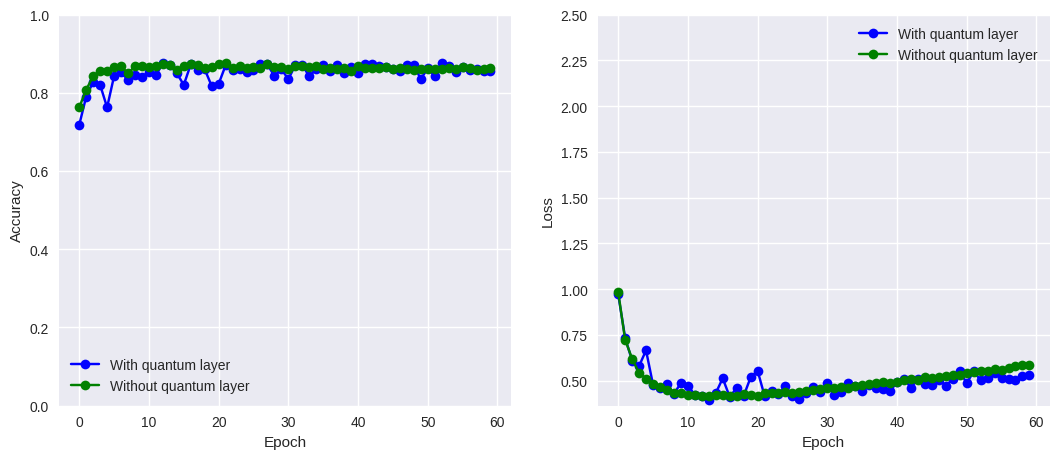

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.savefig('accuracy_loss.png', dpi=200, facecolor='w')
plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 20})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=25)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize=25)


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), fontsize=20)
    plt.title(title)
    plt.show()
    #%%

13/13 [==============================] - 0s 1ms/step
[7 6 1 0 4 1 4 9 6 9 0 2 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 5 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 5 9 2 7 9 2 4 3 0 7 0 2 7
 1 7 3 7 9 7 9 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 3 6 9 6 0 5 4 9 9 2 1 9 4 8
 7 3 9 7 9 4 4 9 2 5 6 7 6 4 9 0 5 8 5 6 6 5 7 8 1 0 1 6 7 6 7 3 1 7 1 8 2
 0 4 9 9 5 5 1 5 6 0 3 4 4 6 5 4 6 5 4 5 1 4 4 7 3 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 3 0 3 1 6 9 2 3 6 1 1 1 3 9 5 2 9 4 7 3 3 9 0 3 5 5 5 7 2
 2 7 1 2 8 4 1 7 2 3 8 7 7 9 2 2 4 1 5 9 0 3 7 5 0 6 4 2 4 1 9 5 7 7 2 8 2
 6 8 1 7 7 9 1 8 1 5 0 3 0 1 9 9 4 1 8 2 1 2 9 7 7 7 2 6 4 1 6 4 2 9 2 0 9
 0 0 2 8 6 7 1 7 4 0 2 9 4 1 3 0 0 5 1 9 6 1 5 5 7 7 9 3 7 9 6 0 7 1 1 2 1
 5 3 3 9 7 0 6 5 6 1 3 8 1 0 5 1 7 1 5 5 6 1 8 5 1 1 9 4 6 7 2 8 0 6 5 6 3
 7 2 0 8 8 5 9 1 1 4 0 7 3 7 6 1 5 2 1 9 2 8 6 1 9 5 2 5 4 4]


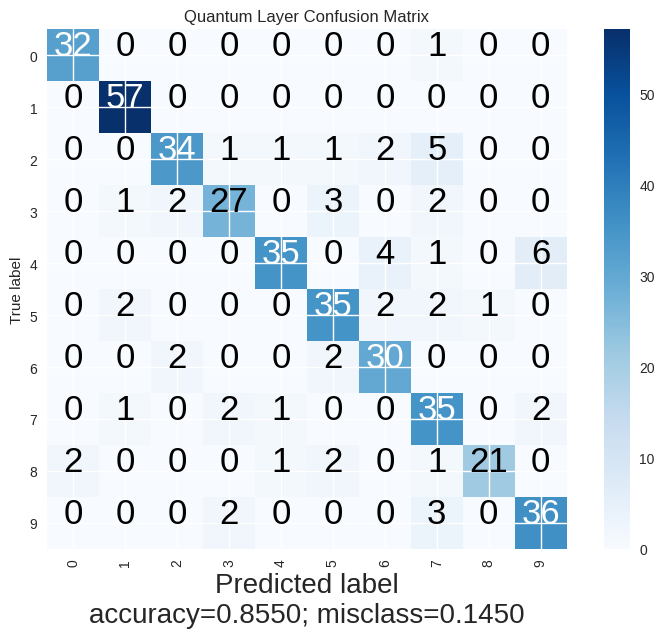

In [ ]:
import sklearn.metrics as metrics

y_pred=q_model.predict(q_test_images)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm = metrics.confusion_matrix(test_labels, y_pred)

plot_confusion_matrix(cm ,
    normalize    = False,
    target_names = ['0','1','2','3','4','5','6','7','8','9'],
    title        = "Quantum Layer Confusion Matrix")

13/13 [==============================] - 0s 1ms/step
[7 6 1 0 4 1 4 9 4 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 0 7 2 7
 1 2 1 1 7 4 2 5 5 1 2 4 4 6 3 5 5 2 0 4 1 9 5 7 8 9 2 7 4 2 4 3 0 7 0 2 7
 1 7 3 2 9 7 9 6 2 7 8 4 7 3 6 1 3 6 9 3 1 4 1 3 6 7 6 0 5 4 2 9 2 1 9 4 8
 7 3 9 7 9 4 4 9 2 5 4 7 6 4 9 0 5 8 5 6 6 5 7 8 1 0 1 6 4 6 7 3 1 7 1 8 2
 0 9 9 2 5 5 1 5 6 0 3 9 4 6 5 4 6 5 4 5 1 4 4 7 3 3 2 7 1 8 1 8 1 8 5 0 8
 9 2 5 0 1 1 1 0 3 0 3 1 6 9 2 3 6 1 1 1 3 9 5 2 9 4 0 9 3 9 0 3 5 7 5 7 2
 2 7 1 2 8 4 1 7 5 3 8 7 7 9 2 2 4 1 5 5 9 3 7 5 0 6 4 2 4 1 9 5 7 7 2 8 2
 6 8 1 7 7 3 1 8 1 5 0 3 0 1 9 7 9 1 8 2 1 2 9 2 5 9 2 6 4 1 6 4 2 9 2 0 4
 0 0 2 8 6 7 1 2 4 0 2 9 4 3 3 0 0 5 1 9 6 8 3 5 7 7 9 3 0 4 2 0 7 1 1 2 1
 5 3 3 9 7 3 6 5 7 1 3 8 1 0 5 1 7 1 5 3 6 1 8 5 1 9 9 4 6 7 2 5 0 6 5 6 3
 7 2 0 8 8 5 9 1 1 4 0 3 3 7 6 1 5 2 1 9 2 8 6 1 9 5 2 8 4 4]


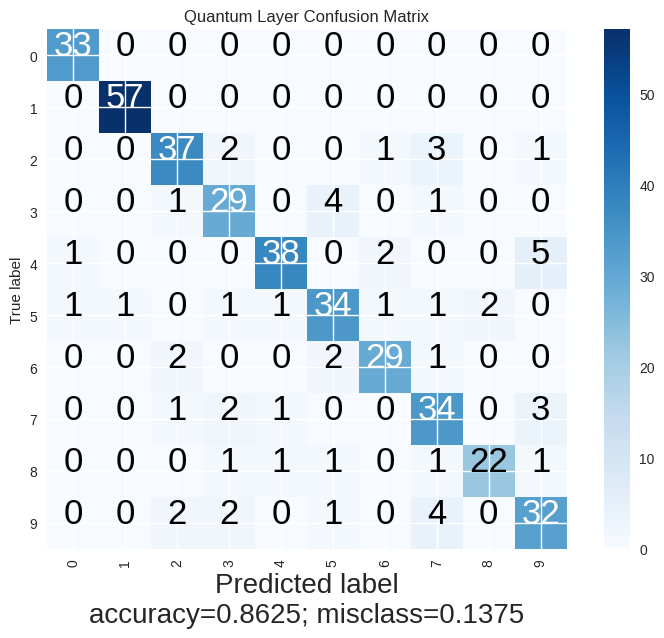

In [ ]:
import sklearn.metrics as metrics

y_pred=c_model.predict(test_images)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

cm = metrics.confusion_matrix(test_labels, y_pred)

plot_confusion_matrix(cm ,
    normalize    = False,
    target_names = ['0','1','2','3','4','5','6','7','8','9'],
    title        = "Quantum Layer Confusion Matrix")